In [1]:
import glob
import re
import os
import os.path
import tarfile
import random

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

In [9]:
GDRIVE = '/content/drive'
DATA_DIR = '{}/MyDrive/ime/allan-matheus-mestrado/data/'.format(GDRIVE)
MODEL_DIR = '{}/MyDrive/ime/allan-matheus-mestrado/models/'.format(GDRIVE)
TEMP_DIR = '/content/data'

In [10]:
from google.colab import drive
drive.mount(GDRIVE)

Mounted at /content/drive


In [11]:
os.makedirs(TEMP_DIR, exist_ok=True)

## Importar dataset

 - por aplicação
 - serparar testes por execução (`task_id`)
 - preparar X, y para treinamento

In [8]:
pd.DataFrame({'x': [1,2,3,4]}).diff().isna()

,x
0,True
1,False
2,False
3,False


In [12]:
def load(app, resources, target_resource, windows=3, test_size=0.2, filepath=None, random_state=None,
         target_step=None):
    features = ['%s-1' % r for r in resources]
    features.extend(['%s-diff-%d' % (r, d)
                    for r in resources
                    for d in reversed(range(1, 1 + windows))])
    target = '%s-up' % target_resource
    baseline = '%s-baseline' % target_resource
    if target_step is not None:
        target = '%s+%d' % (target, target_step)
        #baseline = '%s+%d' % (baseline, target_step)
    if random_state is not None:
        random.seed(random_state)
    filepath = filepath or os.path.join(DATA_DIR, 'binclf-new.csv')
    df = pd.read_csv(filepath)
    print('Any na:', df.isna().any())
    df = df[df['application'] == app]
    df.pop('application')
    by_task = df.groupby('task_id')
    tasks = list(by_task.groups.keys())
    test_size = test_size if test_size > 1 else int(test_size * len(tasks))
    test_tasks = []
    for _ in range(test_size):
        t = random.choice(tasks)
        tasks.remove(t)
        test_tasks.append(t)
    usecols = features + [target, baseline]
    train = pd.concat((by_task.get_group(task)[usecols] for task in tasks),
                      ignore_index=True)
    test = pd.concat((by_task.get_group(task)[usecols] for task in test_tasks),
                     ignore_index=True)
    return train, test, target, baseline

In [13]:
def make_X_y_baseline(df, target, baseline):
    y = df.pop(target).values
    y_base = df.pop(baseline).values
    X = df.values
    return X, y, y_base

## Treinamento de modelo

In [14]:
def grid_search(X, y, search_spaces, scoring='roc_auc', n_splits=5, random_state=None, verbose=0):
    results = []
    for space in search_spaces:
        print('# Fitting for %s' % space['name'])
        # cv = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=2, random_state=random_state)
        # cv = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
        cv = StratifiedShuffleSplit(n_splits=n_splits, random_state=random_state)
        search = GridSearchCV(estimator=space['estimator'],
                                param_grid=space['param_grid'],
                                scoring=scoring, cv=cv, verbose=verbose)
        result = search.fit(X, y)
        results.append((space['name'], result))
    return results

In [15]:
def search_spaces(random_state=None):
    return [
        {
            'name': 'ABC',
            'estimator': Pipeline([('scaler', StandardScaler()), ('abc', AdaBoostClassifier(random_state=random_state))]),
            'param_grid': [{'abc__n_estimators': [50, 100]}]
        },
        {
            'name': 'GNB',
            'estimator': Pipeline([('scaler', StandardScaler()), ('gnb', GaussianNB())]),
            'param_grid': [{'gnb__var_smoothing': [1e-9]}]
        },
        # {
        #     'name': 'QDA',
        #     'estimator': Pipeline([('scaler', StandardScaler()), ('qda', QuadraticDiscriminantAnalysis())]),
        #     'param_grid': [{'qda__reg_param': [0.0]}]
        # },
        {
            'name': 'MLPC',
            'estimator': Pipeline([('scaler', StandardScaler()), ('mlp', MLPClassifier(max_iter=1000, random_state=random_state))]),
            'param_grid': [{'mlp__alpha': [1e-2, 1e-1]}]
        },
        {
            'name': 'RFC',
            'estimator': Pipeline([('scaler', StandardScaler()), ('rfc', RandomForestClassifier(random_state=random_state))]), # max_depth=5, n_estimators=10
            'param_grid': [{'rfc__max_features': [3, 5]}]
        },
        {
            'name': 'SVC',
            'estimator': Pipeline([('scaler', StandardScaler()), ('svc', SVC(random_state=random_state))]),
            'param_grid': [
                {'svc__kernel': ['linear']},
                {'svc__kernel': ['poly'], 'svc__degree': [2, 3]},
                {'svc__kernel': ['rbf'], 'svc__C': [1e-2, 1e-1, 1], 'svc__gamma': ['scale', 'auto']}
            ]
        },
    ]

## Avaliação de modelo

In [16]:
def evaluate_results(results, app, resources, target_resource, baseline):
    names, means, stds, params = [], [], [], []
    for (name, result) in results:
        names.append(name)
        means.append(result.cv_results_['mean_test_score'][result.best_index_])
        stds.append(result.cv_results_['std_test_score'][result.best_index_])
        params.append(result.cv_results_['params'][result.best_index_])
    title = 'Desempenho de modelos para {}\n({}) -> ({})'.format(
        app, ', '.join(resources), target_resource)
    df = pd.DataFrame(dict(model=names, mean_score=means, std_score=stds, params=params))
    df.plot.bar(x='model', y='mean_score', ylabel='score',
                yerr='std_score', rot=0, ylim=(0, 1), figsize=(10, 6),
                title=title)
    plt.axhline(y=baseline, color='black', linestyle='--', label='baseline')
    plt.legend()
    plt.tight_layout()
    baselinedf = pd.DataFrame(dict(model=['baseline'], mean_score=[baseline]))
    df = pd.concat([df, baselinedf], ignore_index=True)
    return df

In [17]:
def plot_scores_by_steps(evals, prefix):
    df = pd.concat([df for (name, df) in evals.items()
                        if name.startswith(prefix)])
    g = sns.relplot(x='steps', y='mean_score', kind='line', markers=True,
                hue='model', style=df['model'] == 'baseline', legend=False,
                data=df)
    g.set_axis_labels("$n$ Passos", "f1-score")
    app, target = prefix.split('_')
    targets = {'cpu': 'CPU', 'io': 'E/S'}
    g.fig.suptitle(f"Passo X f1-score para {app}, prevendo {targets[target]}")
    plt.tight_layout()
    g.fig.subplots_adjust(top=.9)
    plt.legend(df['model'].values)
    plt.savefig(os.path.join(MODEL_DIR, prefix + '.pdf'))

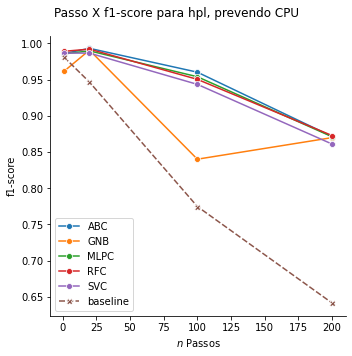

In [ ]:
plot_scores_by_steps(evals, 'hpl_cpu')

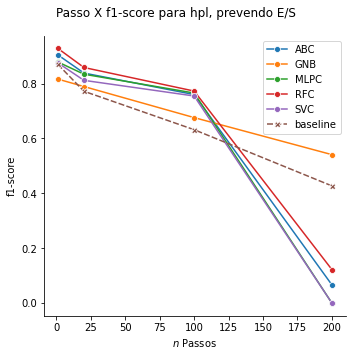

In [ ]:
plot_scores_by_steps(evals, 'hpl_io')

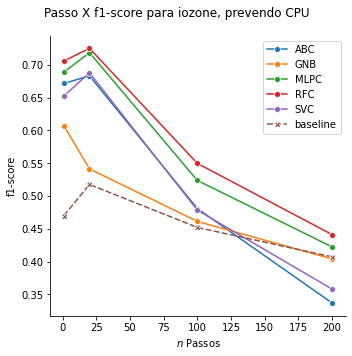

In [ ]:
plot_scores_by_steps(evals, 'iozone_cpu')

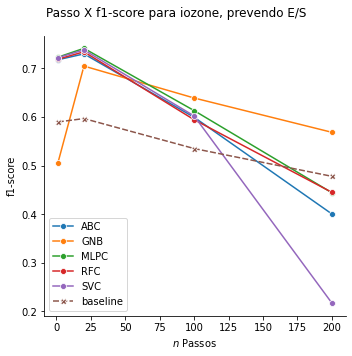

In [ ]:
plot_scores_by_steps(evals, 'iozone_io')

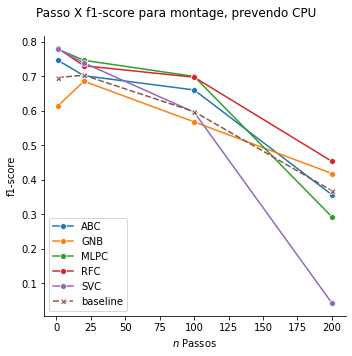

In [ ]:
plot_scores_by_steps(evals, 'montage_cpu')

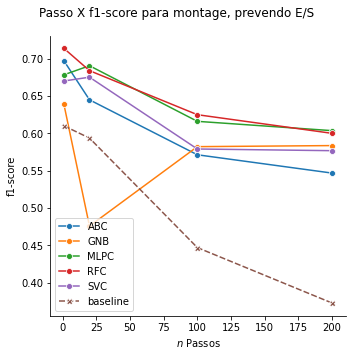

In [ ]:
plot_scores_by_steps(evals, 'montage_io')

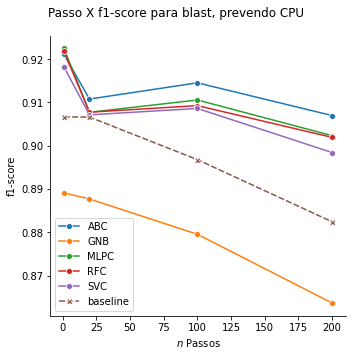

In [ ]:
plot_scores_by_steps(evals, 'blast_cpu')

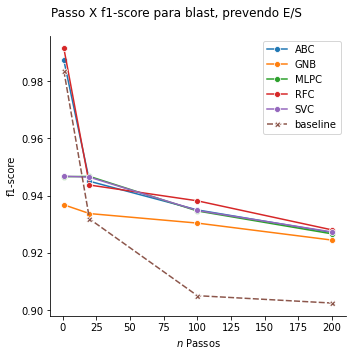

In [ ]:
plot_scores_by_steps(evals, 'blast_io')

## Experimentos

In [18]:
MAX_TRAIN_SAMPLES = 10_000 # Use `None` para todos
results = {}
evals = {}

In [19]:
def run_experiment(app, resources, target_resource, search_spaces, n_splits=5,
                   scoring='roc_auc', random_state=None, verbose=None,
                   max_samples=None, target_step=None):
    train_df, test_df, target, baseline = load(app, resources, target_resource,
                                               random_state=random_state,
                                               target_step=target_step)
    print('train:', train_df.shape, 'test:', test_df.shape,
          'target:', target, 'baseline:', baseline)
    X_train, y_train, y_baseline = make_X_y_baseline(train_df, target, baseline)
    X_train, y_train, y_baseline = X_train[:max_samples], y_train[:max_samples], y_baseline[:max_samples]
    print('X_train:', X_train.shape, 'y_train:', y_train.shape)
    results = grid_search(X_train, y_train,
                          search_spaces, n_splits=n_splits, scoring=scoring,
                          random_state=random_state, verbose=verbose)
    cv = StratifiedShuffleSplit(n_splits=n_splits, random_state=random_state) # TODO: automatic cv class
    baseline = 0
    for _, test_index in cv.split(X_train, y_train):
        y_cv = y_train[test_index]
        y_basecv = y_baseline[test_index]
        #baseline += roc_auc_score(y_cv, y_basecv) # TODO: automatic socoring function
        baseline += f1_score(y_cv, y_basecv) # TODO: automatic socoring function
    baseline /= n_splits
    evaluation = evaluate_results(results, app, resources, target_resource, baseline)
    evaluation['steps'] = (target_step or 1)
    return results, evaluation

Any na: cpu-1                False
cpu-diff-3           False
cpu-diff-2           False
cpu-diff-1           False
io_total-1           False
io_total-diff-3      False
io_total-diff-2      False
io_total-diff-1      False
cpu-up               False
cpu-baseline         False
cpu-up+1             False
cpu-up+2             False
cpu-up+20            False
cpu-up+100           False
cpu-up+200           False
io_total-up          False
io_total-baseline    False
io_total-up+1        False
io_total-up+2        False
io_total-up+20       False
io_total-up+100      False
io_total-up+200      False
application          False
task_id              False
dtype: bool
train: (3254, 10) test: (1595, 10) target: cpu-up baseline: cpu-baseline
X_train: (3254, 8) y_train: (3254,)
# Fitting for ABC
# Fitting for GNB
# Fitting for MLPC
# Fitting for RFC
# Fitting for SVC


,model,mean_score,std_score,params,steps
0,ABC,0.985944,0.003066,{'abc__n_estimators': 50},1
1,GNB,0.961407,0.008586,{'gnb__var_smoothing': 1e-09},1
2,MLPC,0.985551,0.002053,{'mlp__alpha': 0.01},1
3,RFC,0.989112,0.002557,{'rfc__max_features': 3},1
4,SVC,0.986637,0.001585,"{'svc__C': 1, 'svc__gamma': 'scale', 'svc__ker...",1
5,baseline,0.981272,NaN,NaN,1


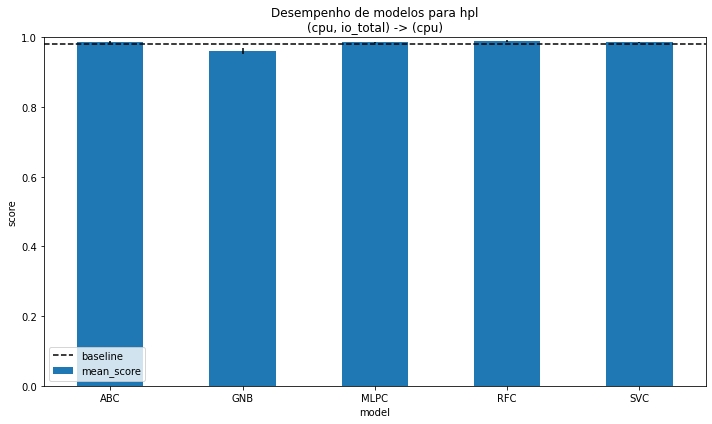

In [20]:
results['hpl_cpu'], evals['hpl_cpu'] = run_experiment(app='hpl', resources=['cpu', 'io_total'],
               target_resource='cpu', search_spaces=search_spaces(random_state=0),
               scoring='f1', random_state=0, verbose=0, max_samples=MAX_TRAIN_SAMPLES)
evals['hpl_cpu']

### HPL

train: (3254, 10) test: (1595, 10) target: cpu-up baseline: cpu-baseline
X_train: (3254, 8) y_train: (3254,)
# Fitting for ABC
# Fitting for GNB
# Fitting for MLPC
# Fitting for RFC
# Fitting for SVC


,model,mean_score,std_score,params,steps
0,ABC,0.985944,0.003066,{'abc__n_estimators': 50},1
1,GNB,0.961407,0.008586,{'gnb__var_smoothing': 1e-09},1
2,MLPC,0.985551,0.002053,{'mlp__alpha': 0.01},1
3,RFC,0.989112,0.002557,{'rfc__max_features': 3},1
4,SVC,0.986637,0.001585,"{'svc__C': 1, 'svc__gamma': 'scale', 'svc__ker...",1
5,baseline,0.981272,NaN,NaN,1


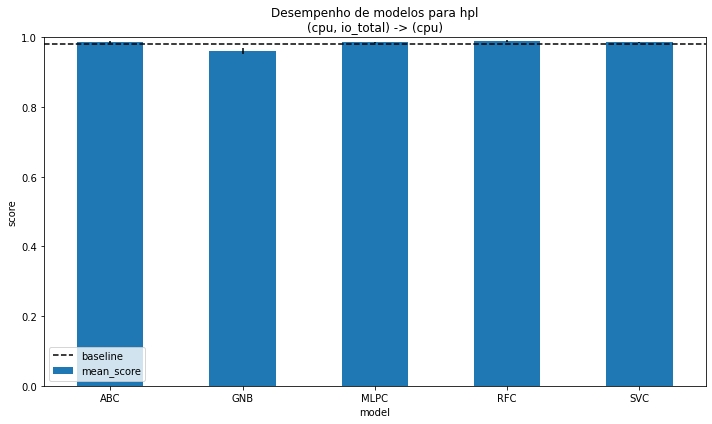

In [ ]:
results['hpl_cpu'], evals['hpl_cpu'] = run_experiment(app='hpl', resources=['cpu', 'io_total'],
               target_resource='cpu', search_spaces=search_spaces(random_state=0),
               scoring='f1', random_state=0, verbose=0, max_samples=MAX_TRAIN_SAMPLES)
evals['hpl_cpu']

train: (3254, 10) test: (1595, 10) target: cpu-up+20 baseline: cpu-baseline
X_train: (3254, 8) y_train: (3254,)
# Fitting for ABC
# Fitting for GNB
# Fitting for MLPC
# Fitting for RFC
# Fitting for SVC


,model,mean_score,std_score,params,steps
0,ABC,0.993224,0.001321,{'abc__n_estimators': 50},20
1,GNB,0.990736,0.002355,{'gnb__var_smoothing': 1e-09},20
2,MLPC,0.989728,0.003216,{'mlp__alpha': 0.01},20
3,RFC,0.992141,0.002144,{'rfc__max_features': 5},20
4,SVC,0.986621,0.003214,{'svc__kernel': 'linear'},20
5,baseline,0.946606,NaN,NaN,20


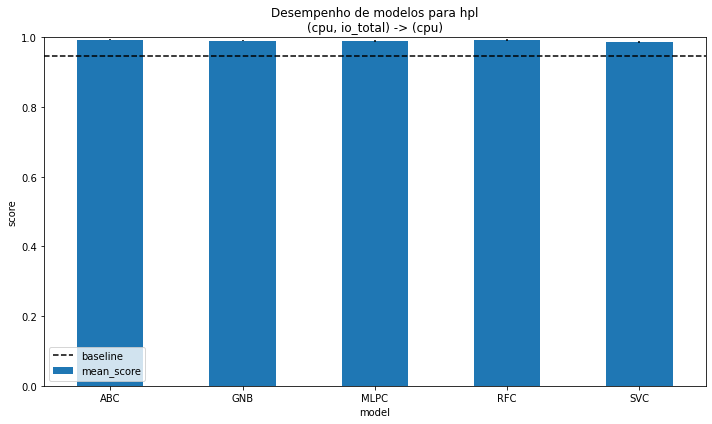

In [ ]:
results['hpl_cpu+20'], evals['hpl_cpu+20'] = run_experiment(app='hpl', resources=['cpu', 'io_total'],
               target_resource='cpu', search_spaces=search_spaces(random_state=0),
               scoring='f1', random_state=0, verbose=0,
               max_samples=MAX_TRAIN_SAMPLES, target_step=20)
evals['hpl_cpu+20']

train: (3254, 10) test: (1595, 10) target: cpu-up+100 baseline: cpu-baseline
X_train: (3254, 8) y_train: (3254,)
# Fitting for ABC
# Fitting for GNB
# Fitting for MLPC
# Fitting for RFC
# Fitting for SVC


,model,mean_score,std_score,params,steps
0,ABC,0.960324,0.005971,{'abc__n_estimators': 100},100
1,GNB,0.840158,0.012402,{'gnb__var_smoothing': 1e-09},100
2,MLPC,0.954018,0.011744,{'mlp__alpha': 0.01},100
3,RFC,0.950409,0.007516,{'rfc__max_features': 3},100
4,SVC,0.943485,0.012971,"{'svc__C': 1, 'svc__gamma': 'scale', 'svc__ker...",100
5,baseline,0.774826,NaN,NaN,100


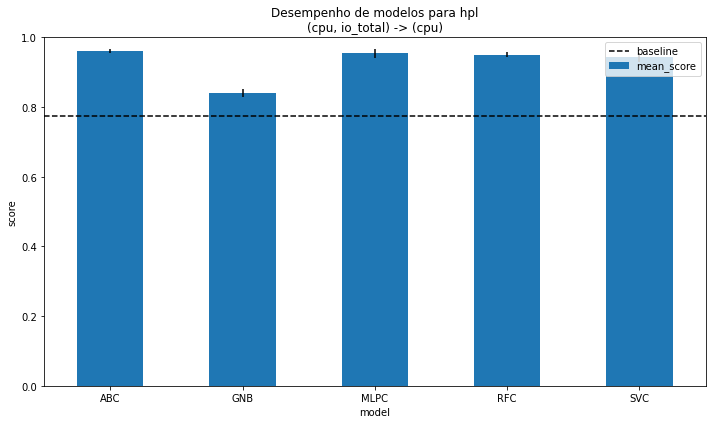

In [ ]:
results['hpl_cpu+100'], evals['hpl_cpu+100'] = run_experiment(app='hpl', resources=['cpu', 'io_total'],
               target_resource='cpu', search_spaces=search_spaces(random_state=0),
               scoring='f1', random_state=0, verbose=0,
               max_samples=MAX_TRAIN_SAMPLES, target_step=100)
evals['hpl_cpu+100']

train: (3254, 10) test: (1595, 10) target: cpu-up+200 baseline: cpu-baseline
X_train: (3254, 8) y_train: (3254,)
# Fitting for ABC
# Fitting for GNB
# Fitting for MLPC
# Fitting for RFC
# Fitting for SVC


,model,mean_score,std_score,params,steps
0,ABC,0.871441,0.018716,{'abc__n_estimators': 100},200
1,GNB,0.869962,0.010850,{'gnb__var_smoothing': 1e-09},200
2,MLPC,0.871103,0.011790,{'mlp__alpha': 0.01},200
3,RFC,0.872743,0.017307,{'rfc__max_features': 3},200
4,SVC,0.860997,0.011257,{'svc__kernel': 'linear'},200
5,baseline,0.641501,NaN,NaN,200


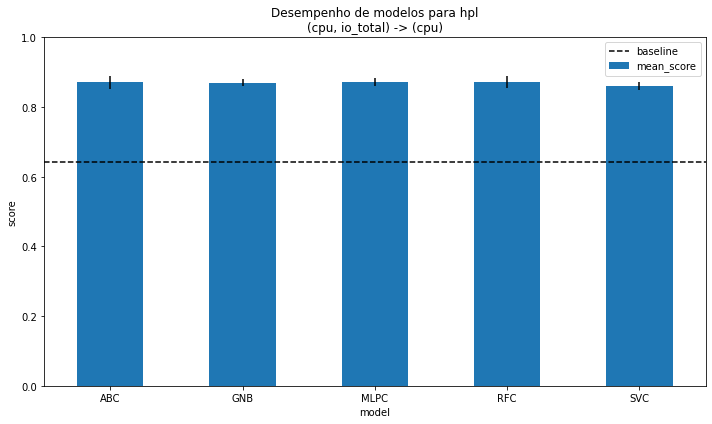

In [ ]:
results['hpl_cpu+200'], evals['hpl_cpu+200'] = run_experiment(app='hpl', resources=['cpu', 'io_total'],
               target_resource='cpu', search_spaces=search_spaces(random_state=0),
               scoring='f1', random_state=0, verbose=0,
               max_samples=MAX_TRAIN_SAMPLES, target_step=200)
evals['hpl_cpu+200']

train: (3254, 10) test: (1595, 10) target: io_total-up baseline: io_total-baseline
X_train: (3254, 8) y_train: (3254,)
# Fitting for ABC
# Fitting for GNB
# Fitting for MLPC
# Fitting for RFC
# Fitting for SVC


,model,mean_score,std_score,params,steps
0,ABC,0.904897,0.005969,{'abc__n_estimators': 100},1
1,GNB,0.816514,0.011255,{'gnb__var_smoothing': 1e-09},1
2,MLPC,0.879049,0.012816,{'mlp__alpha': 0.01},1
3,RFC,0.928578,0.007997,{'rfc__max_features': 5},1
4,SVC,0.875909,0.008478,"{'svc__C': 1, 'svc__gamma': 'scale', 'svc__ker...",1
5,baseline,0.870390,NaN,NaN,1


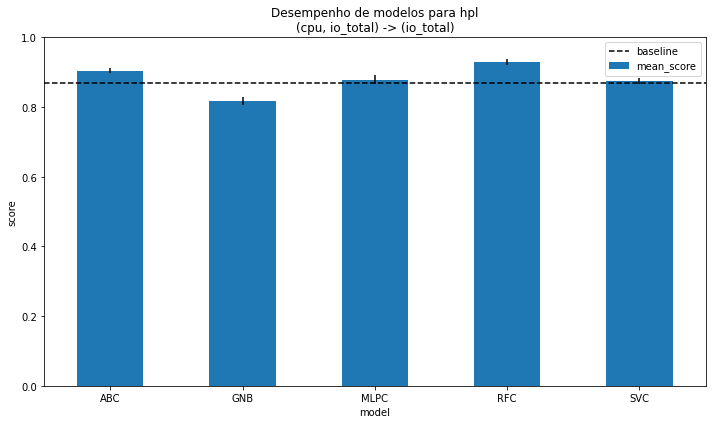

In [ ]:
results['hpl_io'], evals['hpl_io'] = run_experiment(app='hpl', resources=['cpu', 'io_total'],
               target_resource='io_total', search_spaces=search_spaces(random_state=0),
               scoring='f1', random_state=0, verbose=0, max_samples=MAX_TRAIN_SAMPLES)
evals['hpl_io']

train: (3254, 10) test: (1595, 10) target: io_total-up+20 baseline: io_total-baseline
X_train: (3254, 8) y_train: (3254,)
# Fitting for ABC
# Fitting for GNB
# Fitting for MLPC
# Fitting for RFC
# Fitting for SVC


,model,mean_score,std_score,params,steps
0,ABC,0.838467,0.008147,{'abc__n_estimators': 100},20
1,GNB,0.789346,0.004453,{'gnb__var_smoothing': 1e-09},20
2,MLPC,0.834266,0.011982,{'mlp__alpha': 0.01},20
3,RFC,0.858737,0.005295,{'rfc__max_features': 5},20
4,SVC,0.811889,0.014030,"{'svc__C': 1, 'svc__gamma': 'scale', 'svc__ker...",20
5,baseline,0.772084,NaN,NaN,20


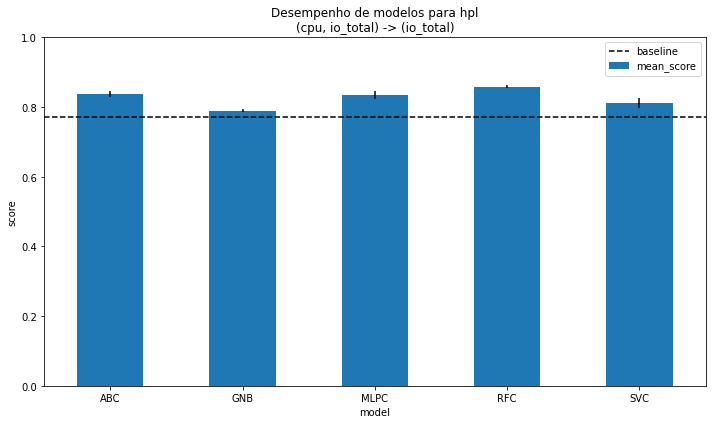

In [ ]:
results['hpl_io+20'], evals['hpl_io+20'] = run_experiment(app='hpl', resources=['cpu', 'io_total'],
               target_resource='io_total', search_spaces=search_spaces(random_state=0),
               scoring='f1', random_state=0, verbose=0,
               max_samples=MAX_TRAIN_SAMPLES, target_step=20)
evals['hpl_io+20']

train: (3254, 10) test: (1595, 10) target: io_total-up+100 baseline: io_total-baseline
X_train: (3254, 8) y_train: (3254,)
# Fitting for ABC
# Fitting for GNB
# Fitting for MLPC
# Fitting for RFC
# Fitting for SVC


,model,mean_score,std_score,params,steps
0,ABC,0.760106,0.018012,{'abc__n_estimators': 100},100
1,GNB,0.676095,0.015715,{'gnb__var_smoothing': 1e-09},100
2,MLPC,0.765655,0.022901,{'mlp__alpha': 0.01},100
3,RFC,0.772801,0.014254,{'rfc__max_features': 5},100
4,SVC,0.754823,0.021691,"{'svc__C': 0.01, 'svc__gamma': 'scale', 'svc__...",100
5,baseline,0.632009,NaN,NaN,100


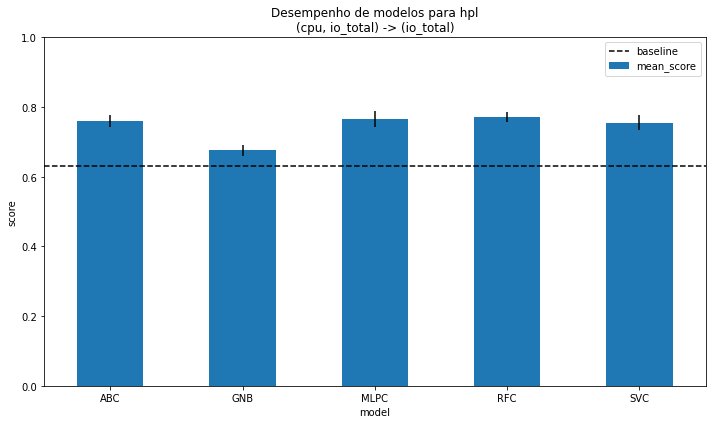

In [ ]:
results['hpl_io+100'], evals['hpl_io+100'] = run_experiment(app='hpl', resources=['cpu', 'io_total'],
               target_resource='io_total', search_spaces=search_spaces(random_state=0),
               scoring='f1', random_state=0, verbose=0,
               max_samples=MAX_TRAIN_SAMPLES, target_step=100)
evals['hpl_io+100']

train: (3254, 10) test: (1595, 10) target: io_total-up+200 baseline: io_total-baseline
X_train: (3254, 8) y_train: (3254,)
# Fitting for ABC
# Fitting for GNB
# Fitting for MLPC
# Fitting for RFC
# Fitting for SVC


,model,mean_score,std_score,params,steps
0,ABC,0.066431,0.046610,{'abc__n_estimators': 100},200
1,GNB,0.541058,0.016672,{'gnb__var_smoothing': 1e-09},200
2,MLPC,0.000000,0.000000,{'mlp__alpha': 0.01},200
3,RFC,0.122115,0.040089,{'rfc__max_features': 5},200
4,SVC,0.000000,0.000000,{'svc__kernel': 'linear'},200
5,baseline,0.427166,NaN,NaN,200


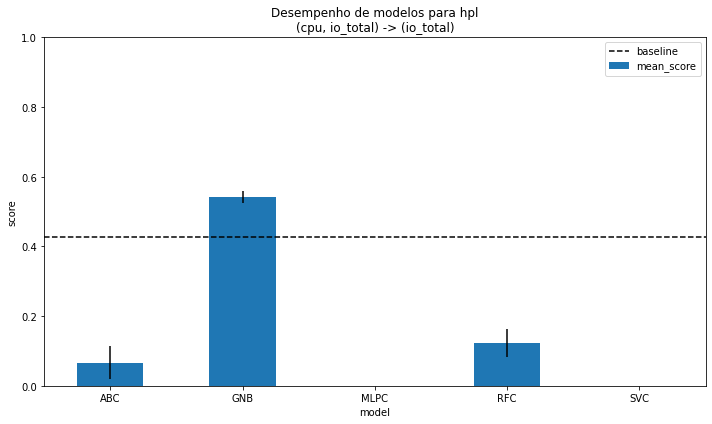

In [ ]:
results['hpl_io+200'], evals['hpl_io+200'] = run_experiment(app='hpl', resources=['cpu', 'io_total'],
               target_resource='io_total', search_spaces=search_spaces(random_state=0),
               scoring='f1', random_state=0, verbose=0,
               max_samples=MAX_TRAIN_SAMPLES, target_step=200)
evals['hpl_io+200']

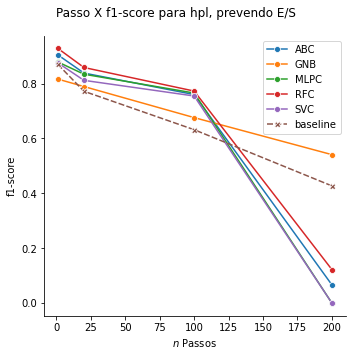

In [ ]:
plot_scores_by_steps(evals, 'hpl_io')

### IOzone

train: (10672, 10) test: (1956, 10) target: cpu-up baseline: cpu-baseline
X_train: (10000, 8) y_train: (10000,)
# Fitting for ABC
# Fitting for GNB
# Fitting for MLPC
# Fitting for RFC
# Fitting for SVC


,model,mean_score,std_score,params,steps
0,ABC,0.671487,0.013358,{'abc__n_estimators': 100},1
1,GNB,0.607017,0.015128,{'gnb__var_smoothing': 1e-09},1
2,MLPC,0.688643,0.014255,{'mlp__alpha': 0.01},1
3,RFC,0.705835,0.005390,{'rfc__max_features': 5},1
4,SVC,0.652179,0.011957,"{'svc__C': 1, 'svc__gamma': 'scale', 'svc__ker...",1
5,baseline,0.469942,NaN,NaN,1


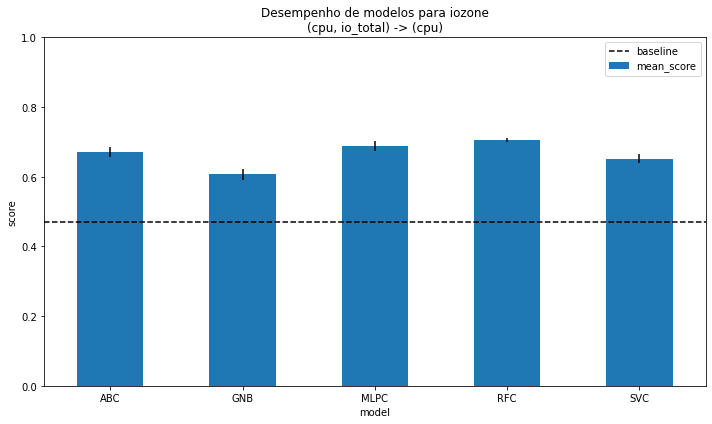

In [ ]:
results['iozone_cpu'], evals['iozone_cpu'] = run_experiment(app='iozone', resources=['cpu', 'io_total'],
               target_resource='cpu', search_spaces=search_spaces(random_state=0),
               scoring='f1', random_state=0, verbose=0, max_samples=MAX_TRAIN_SAMPLES)
evals['iozone_cpu']

train: (10672, 10) test: (1956, 10) target: cpu-up+20 baseline: cpu-baseline
X_train: (10000, 8) y_train: (10000,)
# Fitting for ABC
# Fitting for GNB
# Fitting for MLPC
# Fitting for RFC
# Fitting for SVC


,model,mean_score,std_score,params,steps
0,ABC,0.683130,0.013911,{'abc__n_estimators': 100},20
1,GNB,0.541220,0.018052,{'gnb__var_smoothing': 1e-09},20
2,MLPC,0.718413,0.008760,{'mlp__alpha': 0.01},20
3,RFC,0.725000,0.011173,{'rfc__max_features': 5},20
4,SVC,0.687808,0.010742,"{'svc__C': 1, 'svc__gamma': 'scale', 'svc__ker...",20
5,baseline,0.517568,NaN,NaN,20


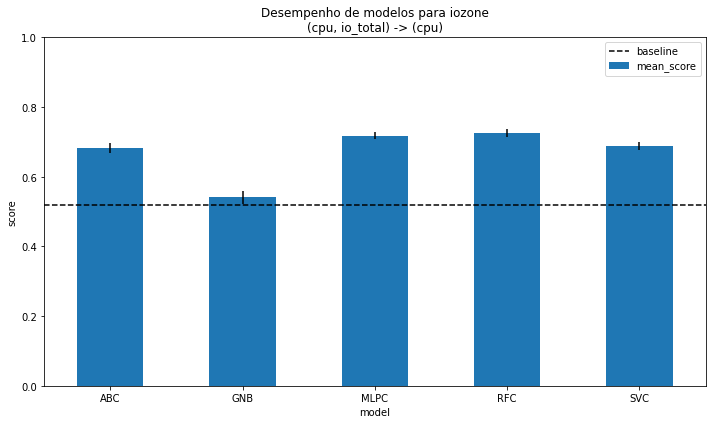

In [ ]:
results['iozone_cpu+20'], evals['iozone_cpu+20'] = run_experiment(app='iozone', resources=['cpu', 'io_total'],
               target_resource='cpu', search_spaces=search_spaces(random_state=0),
               scoring='f1', random_state=0, verbose=0,
               max_samples=MAX_TRAIN_SAMPLES, target_step=20)
evals['iozone_cpu+20']

train: (10672, 10) test: (1956, 10) target: cpu-up+100 baseline: cpu-baseline
X_train: (10000, 8) y_train: (10000,)
# Fitting for ABC
# Fitting for GNB
# Fitting for MLPC
# Fitting for RFC
# Fitting for SVC


,model,mean_score,std_score,params,steps
0,ABC,0.480855,0.022475,{'abc__n_estimators': 100},100
1,GNB,0.461225,0.012682,{'gnb__var_smoothing': 1e-09},100
2,MLPC,0.523683,0.025828,{'mlp__alpha': 0.01},100
3,RFC,0.549656,0.021402,{'rfc__max_features': 5},100
4,SVC,0.478394,0.022641,"{'svc__C': 1, 'svc__gamma': 'scale', 'svc__ker...",100
5,baseline,0.452075,NaN,NaN,100


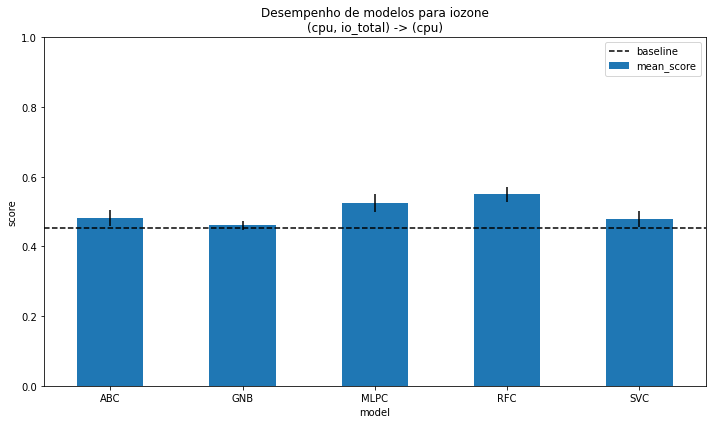

In [ ]:
results['iozone_cpu+100'], evals['iozone_cpu+100'] = run_experiment(app='iozone', resources=['cpu', 'io_total'],
               target_resource='cpu', search_spaces=search_spaces(random_state=0),
               scoring='f1', random_state=0, verbose=0,
               max_samples=MAX_TRAIN_SAMPLES, target_step=100)
evals['iozone_cpu+100']

train: (10672, 10) test: (1956, 10) target: cpu-up+200 baseline: cpu-baseline
X_train: (10000, 8) y_train: (10000,)
# Fitting for ABC
# Fitting for GNB
# Fitting for MLPC
# Fitting for RFC
# Fitting for SVC


,model,mean_score,std_score,params,steps
0,ABC,0.336838,0.024052,{'abc__n_estimators': 100},200
1,GNB,0.404040,0.022231,{'gnb__var_smoothing': 1e-09},200
2,MLPC,0.422348,0.024625,{'mlp__alpha': 0.01},200
3,RFC,0.441089,0.019095,{'rfc__max_features': 5},200
4,SVC,0.358007,0.011479,"{'svc__C': 1, 'svc__gamma': 'scale', 'svc__ker...",200
5,baseline,0.407212,NaN,NaN,200


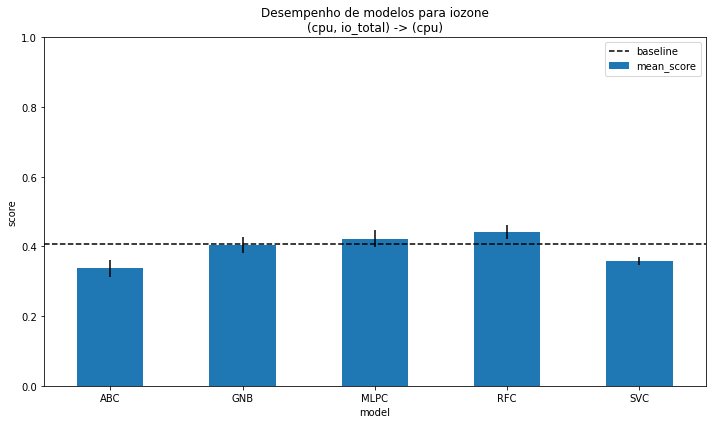

In [ ]:
results['iozone_cpu+200'], evals['iozone_cpu+200'] = run_experiment(app='iozone', resources=['cpu', 'io_total'],
               target_resource='cpu', search_spaces=search_spaces(random_state=0),
               scoring='f1', random_state=0, verbose=0,
               max_samples=MAX_TRAIN_SAMPLES, target_step=200)
evals['iozone_cpu+200']

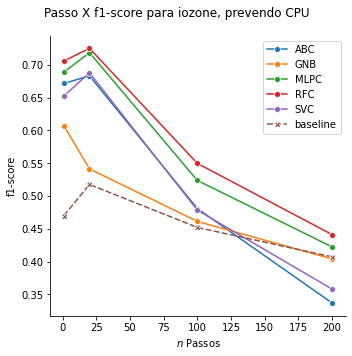

In [ ]:
plot_scores_by_steps(evals, 'iozone_cpu')

train: (10672, 10) test: (1956, 10) target: io_total-up baseline: io_total-baseline
X_train: (10000, 8) y_train: (10000,)
# Fitting for ABC
# Fitting for GNB
# Fitting for MLPC
# Fitting for RFC
# Fitting for SVC


,model,mean_score,std_score,params,steps
0,ABC,0.717797,0.013400,{'abc__n_estimators': 100},1
1,GNB,0.504562,0.008949,{'gnb__var_smoothing': 1e-09},1
2,MLPC,0.723097,0.009378,{'mlp__alpha': 0.1},1
3,RFC,0.718902,0.015507,{'rfc__max_features': 5},1
4,SVC,0.722126,0.013180,"{'svc__C': 0.1, 'svc__gamma': 'scale', 'svc__k...",1
5,baseline,0.589788,NaN,NaN,1


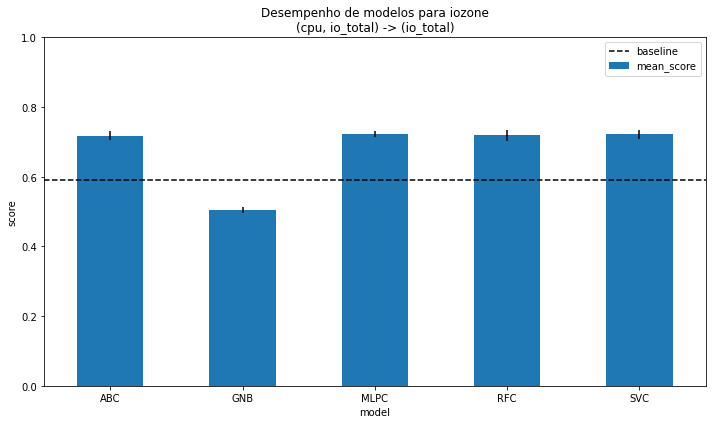

In [ ]:
results['iozone_io'], evals['iozone_io'] = run_experiment(app='iozone', resources=['cpu', 'io_total'],
               target_resource='io_total', search_spaces=search_spaces(random_state=0),
               scoring='f1', random_state=0, verbose=0, max_samples=MAX_TRAIN_SAMPLES)
evals['iozone_io']

train: (10672, 10) test: (1956, 10) target: io_total-up+20 baseline: io_total-baseline
X_train: (10000, 8) y_train: (10000,)
# Fitting for ABC
# Fitting for GNB
# Fitting for MLPC
# Fitting for RFC
# Fitting for SVC


,model,mean_score,std_score,params,steps
0,ABC,0.730009,0.005034,{'abc__n_estimators': 50},20
1,GNB,0.704930,0.008341,{'gnb__var_smoothing': 1e-09},20
2,MLPC,0.741410,0.008218,{'mlp__alpha': 0.1},20
3,RFC,0.734318,0.014113,{'rfc__max_features': 5},20
4,SVC,0.738165,0.012456,"{'svc__C': 1, 'svc__gamma': 'auto', 'svc__kern...",20
5,baseline,0.596819,NaN,NaN,20


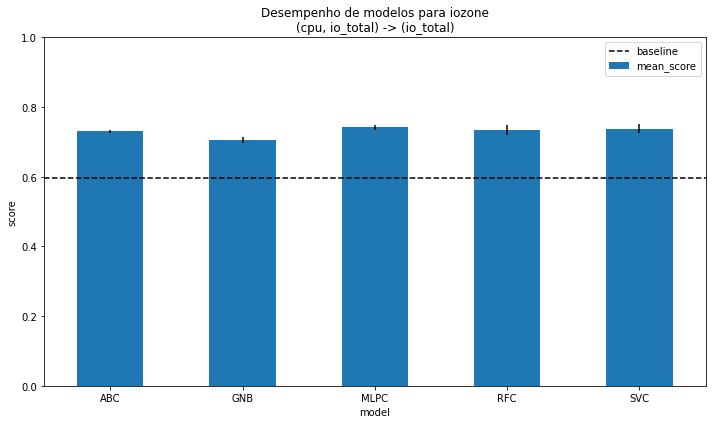

In [ ]:
results['iozone_io+20'], evals['iozone_io+20'] = run_experiment(app='iozone', resources=['cpu', 'io_total'],
               target_resource='io_total', search_spaces=search_spaces(random_state=0),
               scoring='f1', random_state=0, verbose=0, max_samples=MAX_TRAIN_SAMPLES, target_step=20)
evals['iozone_io+20']

train: (10672, 10) test: (1956, 10) target: io_total-up+100 baseline: io_total-baseline
X_train: (10000, 8) y_train: (10000,)
# Fitting for ABC
# Fitting for GNB
# Fitting for MLPC
# Fitting for RFC
# Fitting for SVC


,model,mean_score,std_score,params,steps
0,ABC,0.599476,0.022047,{'abc__n_estimators': 100},100
1,GNB,0.639157,0.006361,{'gnb__var_smoothing': 1e-09},100
2,MLPC,0.613198,0.021595,{'mlp__alpha': 0.1},100
3,RFC,0.594415,0.011508,{'rfc__max_features': 5},100
4,SVC,0.602193,0.015855,"{'svc__C': 1, 'svc__gamma': 'scale', 'svc__ker...",100
5,baseline,0.535075,NaN,NaN,100


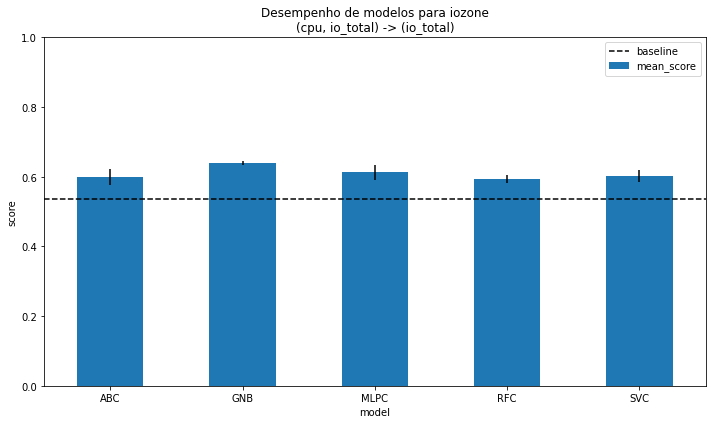

In [ ]:
results['iozone_io+100'], evals['iozone_io+100'] = run_experiment(app='iozone', resources=['cpu', 'io_total'],
               target_resource='io_total', search_spaces=search_spaces(random_state=0),
               scoring='f1', random_state=0, verbose=0, max_samples=MAX_TRAIN_SAMPLES, target_step=100)
evals['iozone_io+100']

train: (10672, 10) test: (1956, 10) target: io_total-up+200 baseline: io_total-baseline
X_train: (10000, 8) y_train: (10000,)
# Fitting for ABC
# Fitting for GNB
# Fitting for MLPC
# Fitting for RFC
# Fitting for SVC


,model,mean_score,std_score,params,steps
0,ABC,0.400406,0.017436,{'abc__n_estimators': 100},200
1,GNB,0.568533,0.006462,{'gnb__var_smoothing': 1e-09},200
2,MLPC,0.444087,0.039127,{'mlp__alpha': 0.01},200
3,RFC,0.444915,0.011730,{'rfc__max_features': 5},200
4,SVC,0.216966,0.019691,"{'svc__C': 1, 'svc__gamma': 'scale', 'svc__ker...",200
5,baseline,0.477922,NaN,NaN,200


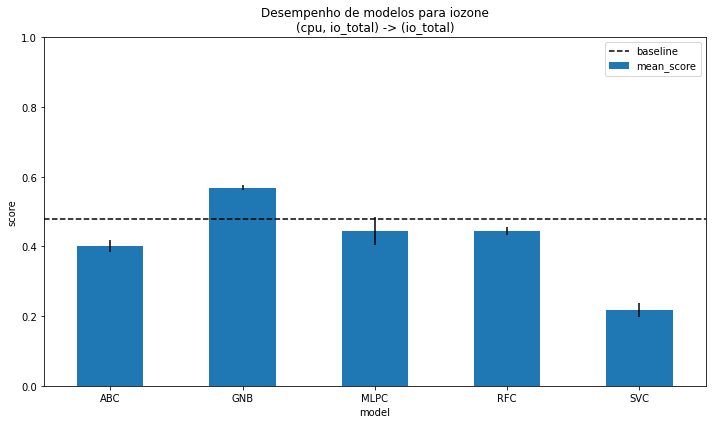

In [ ]:
results['iozone_io+200'], evals['iozone_io+200'] = run_experiment(app='iozone', resources=['cpu', 'io_total'],
               target_resource='io_total', search_spaces=search_spaces(random_state=0),
               scoring='f1', random_state=0, verbose=0, max_samples=MAX_TRAIN_SAMPLES, target_step=200)
evals['iozone_io+200']

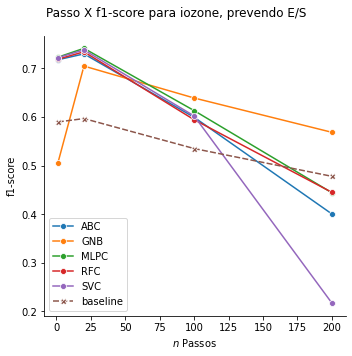

In [ ]:
plot_scores_by_steps(evals, 'iozone_io')

### Montage

train: (5631, 10) test: (1386, 10) target: cpu-up baseline: cpu-baseline
X_train: (5631, 8) y_train: (5631,)
# Fitting for ABC
# Fitting for GNB
# Fitting for MLPC
# Fitting for RFC
# Fitting for SVC


,model,mean_score,std_score,params,steps
0,ABC,0.747253,0.019716,{'abc__n_estimators': 100},1
1,GNB,0.614614,0.021035,{'gnb__var_smoothing': 1e-09},1
2,MLPC,0.779344,0.015732,{'mlp__alpha': 0.1},1
3,RFC,0.781739,0.014164,{'rfc__max_features': 3},1
4,SVC,0.779514,0.015536,"{'svc__C': 1, 'svc__gamma': 'auto', 'svc__kern...",1
5,baseline,0.696902,NaN,NaN,1


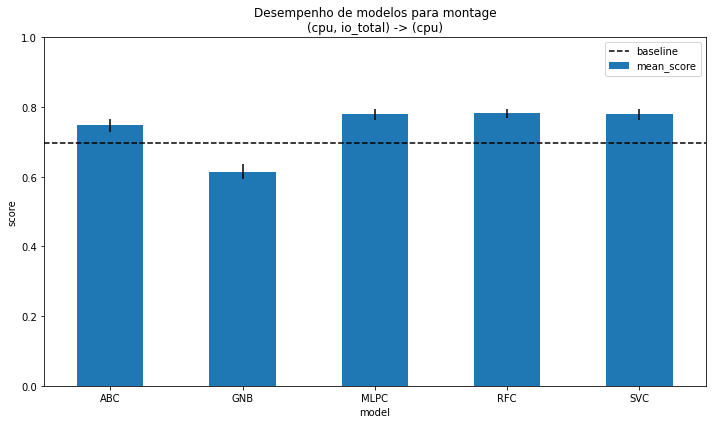

In [ ]:
results['montage_cpu'], evals['montage_cpu'] = run_experiment(app='montage', resources=['cpu', 'io_total'],
               target_resource='cpu', search_spaces=search_spaces(random_state=0),
               scoring='f1', random_state=0, verbose=0, max_samples=MAX_TRAIN_SAMPLES)
evals['montage_cpu']

train: (5631, 10) test: (1386, 10) target: cpu-up+20 baseline: cpu-baseline
X_train: (5631, 8) y_train: (5631,)
# Fitting for ABC
# Fitting for GNB
# Fitting for MLPC
# Fitting for RFC
# Fitting for SVC


,model,mean_score,std_score,params,steps
0,ABC,0.702216,0.016544,{'abc__n_estimators': 100},20
1,GNB,0.686116,0.010563,{'gnb__var_smoothing': 1e-09},20
2,MLPC,0.747019,0.010765,{'mlp__alpha': 0.1},20
3,RFC,0.731171,0.009163,{'rfc__max_features': 3},20
4,SVC,0.739352,0.021503,"{'svc__C': 1, 'svc__gamma': 'scale', 'svc__ker...",20
5,baseline,0.703627,NaN,NaN,20


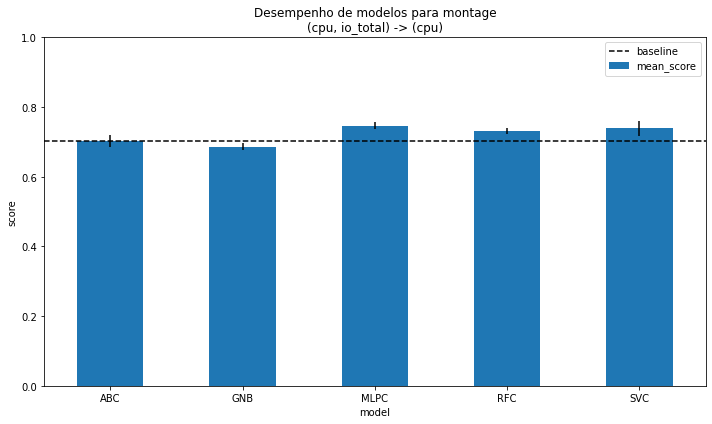

In [ ]:
results['montage_cpu+20'], evals['montage_cpu+20'] = run_experiment(app='montage', resources=['cpu', 'io_total'],
               target_resource='cpu', search_spaces=search_spaces(random_state=0),
               scoring='f1', random_state=0, verbose=0,
               max_samples=MAX_TRAIN_SAMPLES, target_step=20)
evals['montage_cpu+20']

train: (5631, 10) test: (1386, 10) target: cpu-up+100 baseline: cpu-baseline
X_train: (5631, 8) y_train: (5631,)
# Fitting for ABC
# Fitting for GNB
# Fitting for MLPC
# Fitting for RFC
# Fitting for SVC


,model,mean_score,std_score,params,steps
0,ABC,0.660929,0.013985,{'abc__n_estimators': 100},100
1,GNB,0.568243,0.022567,{'gnb__var_smoothing': 1e-09},100
2,MLPC,0.700197,0.020168,{'mlp__alpha': 0.01},100
3,RFC,0.697907,0.014220,{'rfc__max_features': 5},100
4,SVC,0.596363,0.010723,"{'svc__C': 1, 'svc__gamma': 'scale', 'svc__ker...",100
5,baseline,0.597954,NaN,NaN,100


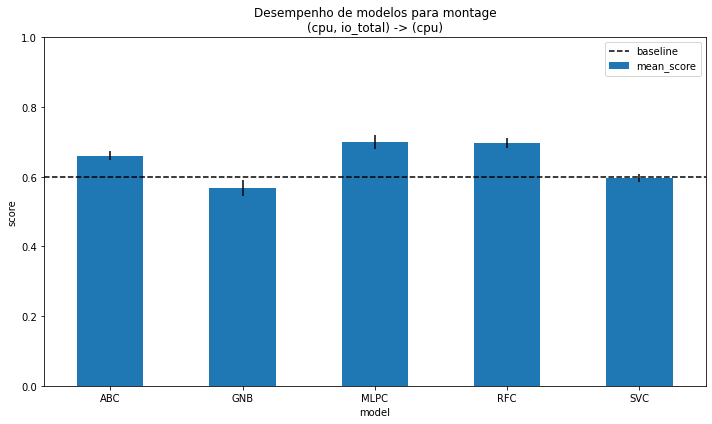

In [ ]:
results['montage_cpu+100'], evals['montage_cpu+100'] = run_experiment(app='montage', resources=['cpu', 'io_total'],
               target_resource='cpu', search_spaces=search_spaces(random_state=0),
               scoring='f1', random_state=0, verbose=0,
               max_samples=MAX_TRAIN_SAMPLES, target_step=100)
evals['montage_cpu+100']

train: (5631, 10) test: (1386, 10) target: cpu-up+200 baseline: cpu-baseline
X_train: (5631, 8) y_train: (5631,)
# Fitting for ABC
# Fitting for GNB
# Fitting for MLPC
# Fitting for RFC
# Fitting for SVC


,model,mean_score,std_score,params,steps
0,ABC,0.356686,0.025637,{'abc__n_estimators': 50},200
1,GNB,0.418357,0.025984,{'gnb__var_smoothing': 1e-09},200
2,MLPC,0.292615,0.131210,{'mlp__alpha': 0.01},200
3,RFC,0.453633,0.024395,{'rfc__max_features': 5},200
4,SVC,0.042250,0.028034,"{'svc__degree': 3, 'svc__kernel': 'poly'}",200
5,baseline,0.368517,NaN,NaN,200


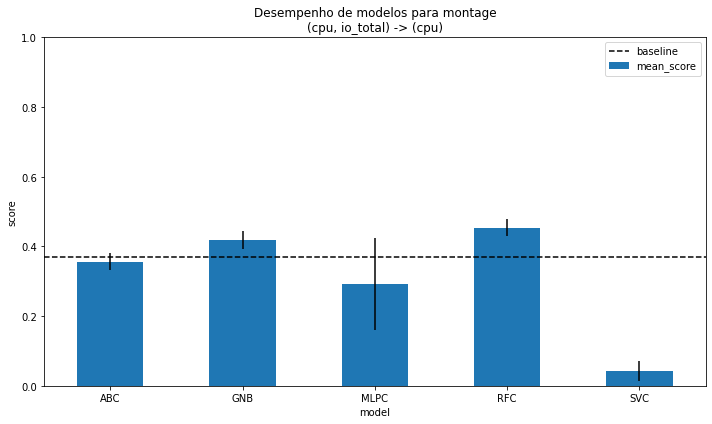

In [ ]:
results['montage_cpu+200'], evals['montage_cpu+200'] = run_experiment(app='montage', resources=['cpu', 'io_total'],
               target_resource='cpu', search_spaces=search_spaces(random_state=0),
               scoring='f1', random_state=0, verbose=0,
               max_samples=MAX_TRAIN_SAMPLES, target_step=200)
evals['montage_cpu+200']

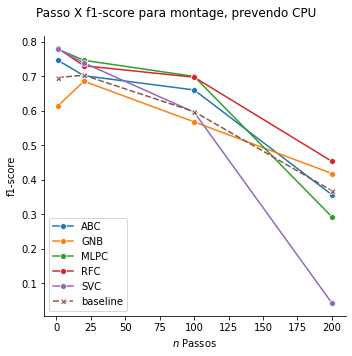

In [ ]:
plot_scores_by_steps(evals, 'montage_cpu')

train: (5631, 10) test: (1386, 10) target: io_total-up baseline: io_total-baseline
X_train: (5631, 8) y_train: (5631,)
# Fitting for ABC
# Fitting for GNB
# Fitting for MLPC
# Fitting for RFC
# Fitting for SVC


,model,mean_score,std_score,params,steps
0,ABC,0.697347,0.015910,{'abc__n_estimators': 50},1
1,GNB,0.639204,0.013038,{'gnb__var_smoothing': 1e-09},1
2,MLPC,0.678474,0.012097,{'mlp__alpha': 0.01},1
3,RFC,0.713946,0.027732,{'rfc__max_features': 3},1
4,SVC,0.670178,0.019347,"{'svc__C': 1, 'svc__gamma': 'scale', 'svc__ker...",1
5,baseline,0.610173,NaN,NaN,1


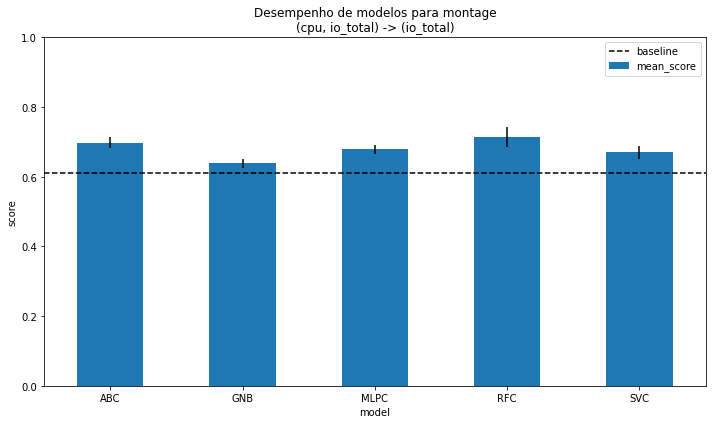

In [ ]:
results['montage_io'], evals['montage_io'] = run_experiment(app='montage', resources=['cpu', 'io_total'],
               target_resource='io_total', search_spaces=search_spaces(random_state=0),
               scoring='f1', random_state=0, verbose=0, max_samples=MAX_TRAIN_SAMPLES)
evals['montage_io']

train: (5631, 10) test: (1386, 10) target: io_total-up+20 baseline: io_total-baseline
X_train: (5631, 8) y_train: (5631,)
# Fitting for ABC
# Fitting for GNB
# Fitting for MLPC
# Fitting for RFC
# Fitting for SVC


,model,mean_score,std_score,params,steps
0,ABC,0.644984,0.016657,{'abc__n_estimators': 100},20
1,GNB,0.475804,0.008251,{'gnb__var_smoothing': 1e-09},20
2,MLPC,0.690657,0.008938,{'mlp__alpha': 0.01},20
3,RFC,0.684063,0.022117,{'rfc__max_features': 3},20
4,SVC,0.675302,0.021013,"{'svc__C': 1, 'svc__gamma': 'scale', 'svc__ker...",20
5,baseline,0.593706,NaN,NaN,20


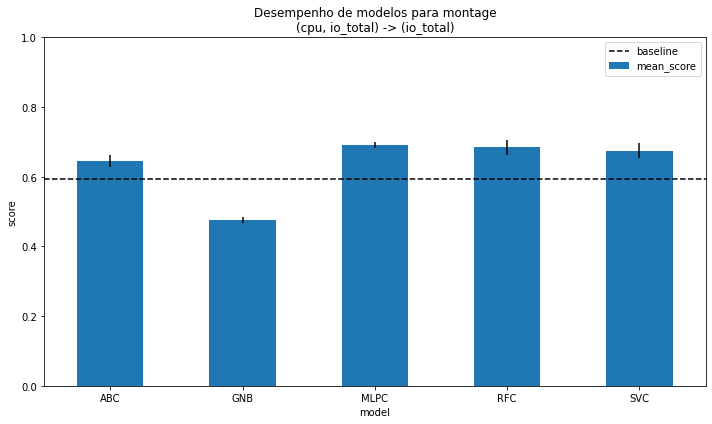

In [ ]:
results['montage_io+20'], evals['montage_io+20'] = run_experiment(app='montage', resources=['cpu', 'io_total'],
               target_resource='io_total', search_spaces=search_spaces(random_state=0),
               scoring='f1', random_state=0, verbose=0,
               max_samples=MAX_TRAIN_SAMPLES, target_step=20)
evals['montage_io+20']

train: (5631, 10) test: (1386, 10) target: io_total-up+100 baseline: io_total-baseline
X_train: (5631, 8) y_train: (5631,)
# Fitting for ABC
# Fitting for GNB
# Fitting for MLPC
# Fitting for RFC
# Fitting for SVC


,model,mean_score,std_score,params,steps
0,ABC,0.571344,0.031926,{'abc__n_estimators': 50},100
1,GNB,0.582242,0.029724,{'gnb__var_smoothing': 1e-09},100
2,MLPC,0.616144,0.024374,{'mlp__alpha': 0.1},100
3,RFC,0.625040,0.020193,{'rfc__max_features': 5},100
4,SVC,0.579096,0.029333,"{'svc__C': 1, 'svc__gamma': 'scale', 'svc__ker...",100
5,baseline,0.446994,NaN,NaN,100


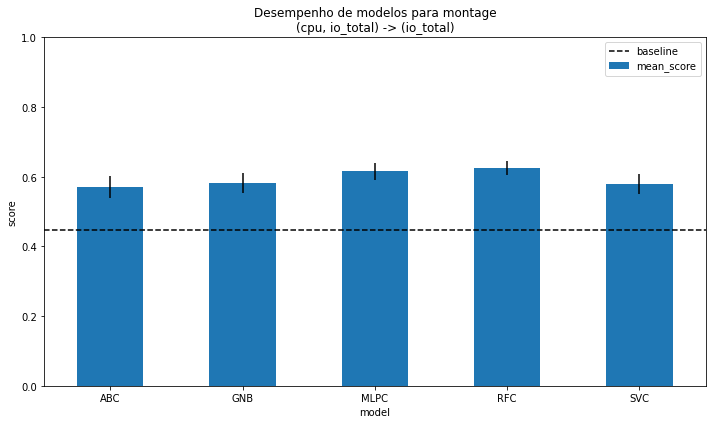

In [ ]:
results['montage_io+100'], evals['montage_io+100'] = run_experiment(app='montage', resources=['cpu', 'io_total'],
               target_resource='io_total', search_spaces=search_spaces(random_state=0),
               scoring='f1', random_state=0, verbose=0,
               max_samples=MAX_TRAIN_SAMPLES, target_step=100)
evals['montage_io+100']

train: (5631, 10) test: (1386, 10) target: io_total-up+200 baseline: io_total-baseline
X_train: (5631, 8) y_train: (5631,)
# Fitting for ABC
# Fitting for GNB
# Fitting for MLPC
# Fitting for RFC
# Fitting for SVC


,model,mean_score,std_score,params,steps
0,ABC,0.546802,0.046778,{'abc__n_estimators': 50},200
1,GNB,0.583672,0.038637,{'gnb__var_smoothing': 1e-09},200
2,MLPC,0.603664,0.055441,{'mlp__alpha': 0.01},200
3,RFC,0.600039,0.056014,{'rfc__max_features': 3},200
4,SVC,0.576824,0.031258,"{'svc__C': 1, 'svc__gamma': 'scale', 'svc__ker...",200
5,baseline,0.372695,NaN,NaN,200


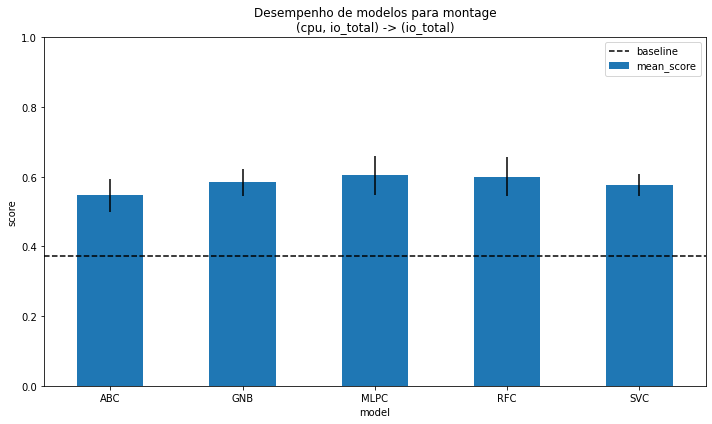

In [ ]:
results['montage_io+200'], evals['montage_io+200'] = run_experiment(app='montage', resources=['cpu', 'io_total'],
               target_resource='io_total', search_spaces=search_spaces(random_state=0),
               scoring='f1', random_state=0, verbose=0,
               max_samples=MAX_TRAIN_SAMPLES, target_step=200)
evals['montage_io+200']

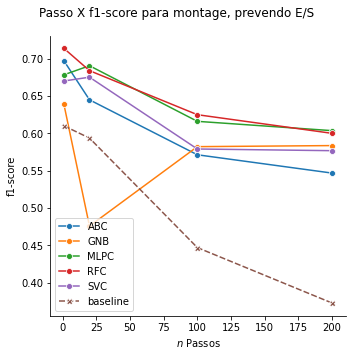

In [ ]:
plot_scores_by_steps(evals, 'montage_io')

### Blast

train: (67469, 10) test: (17308, 10) target: cpu-up baseline: cpu-baseline
X_train: (10000, 8) y_train: (10000,)
# Fitting for ABC
# Fitting for GNB
# Fitting for MLPC
# Fitting for RFC
# Fitting for SVC


,model,mean_score,std_score,params,steps
0,ABC,0.921157,0.002779,{'abc__n_estimators': 50},1
1,GNB,0.889131,0.003274,{'gnb__var_smoothing': 1e-09},1
2,MLPC,0.922509,0.004386,{'mlp__alpha': 0.01},1
3,RFC,0.921839,0.001572,{'rfc__max_features': 3},1
4,SVC,0.918254,0.002855,"{'svc__C': 0.1, 'svc__gamma': 'scale', 'svc__k...",1
5,baseline,0.906678,NaN,NaN,1


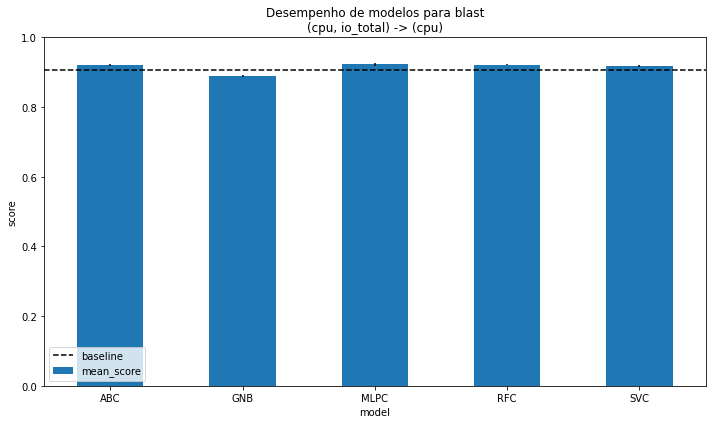

In [ ]:
results['blast_cpu'], evals['blast_cpu'] = run_experiment(app='blast', resources=['cpu', 'io_total'],
               target_resource='cpu', search_spaces=search_spaces(random_state=0),
               scoring='f1', random_state=0, verbose=0, max_samples=MAX_TRAIN_SAMPLES)
evals['blast_cpu']

train: (67469, 10) test: (17308, 10) target: cpu-up+20 baseline: cpu-baseline
X_train: (10000, 8) y_train: (10000,)
# Fitting for ABC
# Fitting for GNB
# Fitting for MLPC
# Fitting for RFC
# Fitting for SVC


,model,mean_score,std_score,params,steps
0,ABC,0.910793,0.006373,{'abc__n_estimators': 50},20
1,GNB,0.887698,0.003511,{'gnb__var_smoothing': 1e-09},20
2,MLPC,0.907731,0.006627,{'mlp__alpha': 0.1},20
3,RFC,0.907758,0.006178,{'rfc__max_features': 3},20
4,SVC,0.907147,0.005954,"{'svc__degree': 3, 'svc__kernel': 'poly'}",20
5,baseline,0.906627,NaN,NaN,20


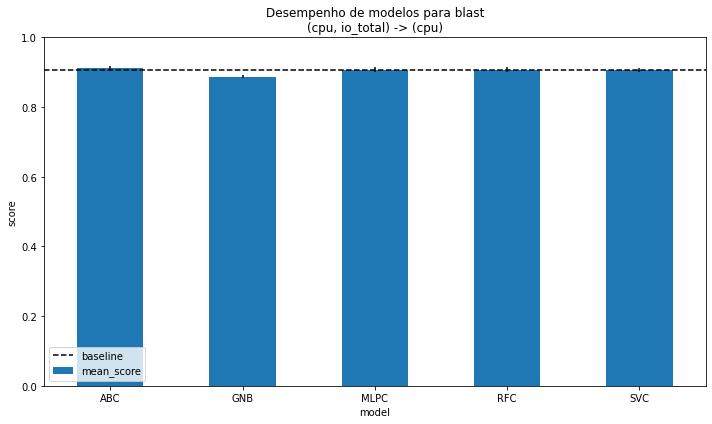

In [ ]:
results['blast_cpu+20'], evals['blast_cpu+20'] = run_experiment(app='blast', resources=['cpu', 'io_total'],
               target_resource='cpu', search_spaces=search_spaces(random_state=0),
               scoring='f1', random_state=0, verbose=0,
               max_samples=MAX_TRAIN_SAMPLES, target_step=20)
evals['blast_cpu+20']

train: (67469, 10) test: (17308, 10) target: cpu-up+100 baseline: cpu-baseline
X_train: (10000, 8) y_train: (10000,)
# Fitting for ABC
# Fitting for GNB
# Fitting for MLPC
# Fitting for RFC
# Fitting for SVC


,model,mean_score,std_score,params,steps
0,ABC,0.914542,0.009390,{'abc__n_estimators': 100},100
1,GNB,0.879561,0.004817,{'gnb__var_smoothing': 1e-09},100
2,MLPC,0.910580,0.008301,{'mlp__alpha': 0.1},100
3,RFC,0.909275,0.006851,{'rfc__max_features': 3},100
4,SVC,0.908621,0.006667,"{'svc__degree': 3, 'svc__kernel': 'poly'}",100
5,baseline,0.896797,NaN,NaN,100


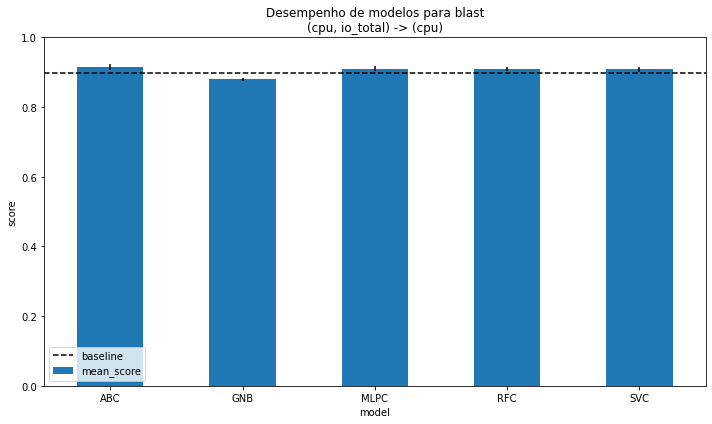

In [ ]:
results['blast_cpu+100'], evals['blast_cpu+100'] = run_experiment(app='blast', resources=['cpu', 'io_total'],
               target_resource='cpu', search_spaces=search_spaces(random_state=0),
               scoring='f1', random_state=0, verbose=0,
               max_samples=MAX_TRAIN_SAMPLES, target_step=100)
evals['blast_cpu+100']

train: (67469, 10) test: (17308, 10) target: cpu-up+200 baseline: cpu-baseline
X_train: (10000, 8) y_train: (10000,)
# Fitting for ABC
# Fitting for GNB
# Fitting for MLPC
# Fitting for RFC
# Fitting for SVC


,model,mean_score,std_score,params,steps
0,ABC,0.906976,0.005573,{'abc__n_estimators': 50},200
1,GNB,0.863661,0.002330,{'gnb__var_smoothing': 1e-09},200
2,MLPC,0.902333,0.007046,{'mlp__alpha': 0.01},200
3,RFC,0.901935,0.007109,{'rfc__max_features': 5},200
4,SVC,0.898437,0.007081,"{'svc__C': 1, 'svc__gamma': 'scale', 'svc__ker...",200
5,baseline,0.882433,NaN,NaN,200


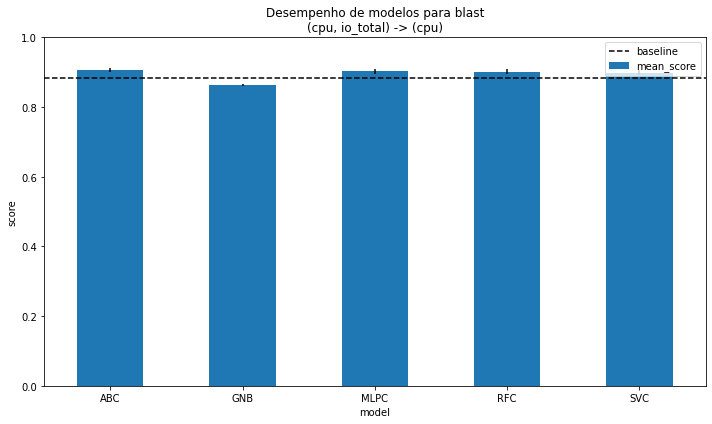

In [ ]:
results['blast_cpu+200'], evals['blast_cpu+200'] = run_experiment(app='blast', resources=['cpu', 'io_total'],
               target_resource='cpu', search_spaces=search_spaces(random_state=0),
               scoring='f1', random_state=0, verbose=0,
               max_samples=MAX_TRAIN_SAMPLES, target_step=200)
evals['blast_cpu+200']

train: (67469, 10) test: (17308, 10) target: io_total-up baseline: io_total-baseline
X_train: (10000, 8) y_train: (10000,)
# Fitting for ABC
# Fitting for GNB
# Fitting for MLPC
# Fitting for RFC
# Fitting for SVC


,model,mean_score,std_score,params,steps
0,ABC,0.987255,0.002812,{'abc__n_estimators': 50},1
1,GNB,0.936804,0.001835,{'gnb__var_smoothing': 1e-09},1
2,MLPC,0.946619,0.001689,{'mlp__alpha': 0.1},1
3,RFC,0.991462,0.001824,{'rfc__max_features': 5},1
4,SVC,0.946800,0.001845,"{'svc__degree': 3, 'svc__kernel': 'poly'}",1
5,baseline,0.983609,NaN,NaN,1


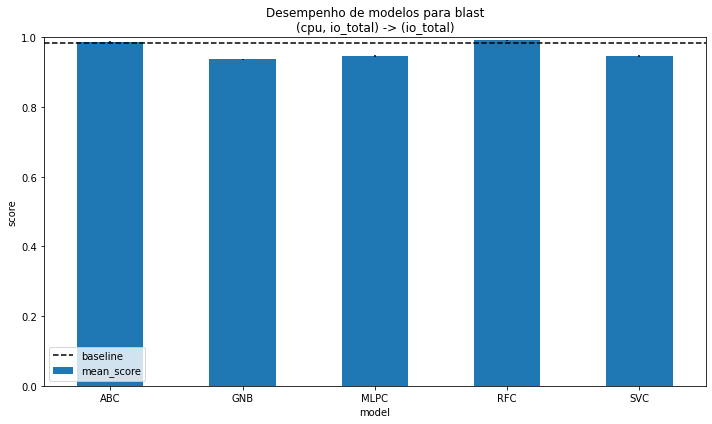

In [ ]:
results['blast_io'], evals['blast_io'] = run_experiment(app='blast', resources=['cpu', 'io_total'],
               target_resource='io_total', search_spaces=search_spaces(random_state=0),
               scoring='f1', random_state=0, verbose=0, max_samples=MAX_TRAIN_SAMPLES)
evals['blast_io']

train: (67469, 10) test: (17308, 10) target: io_total-up+20 baseline: io_total-baseline
X_train: (10000, 8) y_train: (10000,)
# Fitting for ABC
# Fitting for GNB
# Fitting for MLPC
# Fitting for RFC
# Fitting for SVC


,model,mean_score,std_score,params,steps
0,ABC,0.945025,0.002491,{'abc__n_estimators': 100},20
1,GNB,0.933740,0.002401,{'gnb__var_smoothing': 1e-09},20
2,MLPC,0.946725,0.002113,{'mlp__alpha': 0.01},20
3,RFC,0.943705,0.001367,{'rfc__max_features': 3},20
4,SVC,0.946454,0.001473,"{'svc__degree': 3, 'svc__kernel': 'poly'}",20
5,baseline,0.931857,NaN,NaN,20


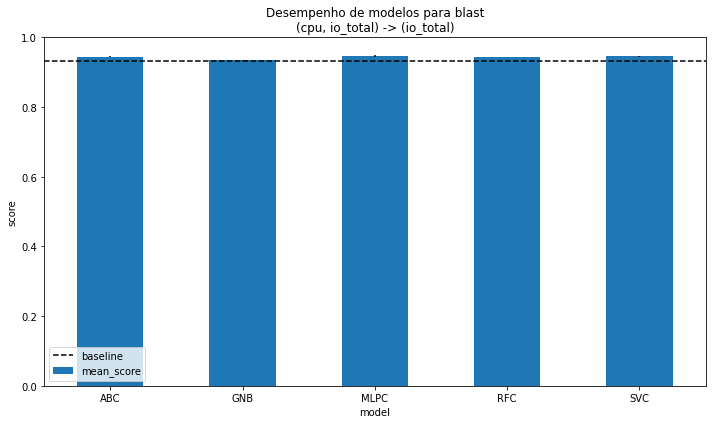

In [ ]:
results['blast_io+20'], evals['blast_io+20'] = run_experiment(app='blast', resources=['cpu', 'io_total'],
               target_resource='io_total', search_spaces=search_spaces(random_state=0),
               scoring='f1', random_state=0, verbose=0,
               max_samples=MAX_TRAIN_SAMPLES, target_step=20)
evals['blast_io+20']

train: (67469, 10) test: (17308, 10) target: io_total-up+100 baseline: io_total-baseline
X_train: (10000, 8) y_train: (10000,)
# Fitting for ABC
# Fitting for GNB
# Fitting for MLPC
# Fitting for RFC
# Fitting for SVC


,model,mean_score,std_score,params,steps
0,ABC,0.935012,0.002230,{'abc__n_estimators': 100},100
1,GNB,0.930412,0.002188,{'gnb__var_smoothing': 1e-09},100
2,MLPC,0.934646,0.001231,{'mlp__alpha': 0.01},100
3,RFC,0.938190,0.000967,{'rfc__max_features': 3},100
4,SVC,0.934817,0.001337,"{'svc__C': 1, 'svc__gamma': 'scale', 'svc__ker...",100
5,baseline,0.905052,NaN,NaN,100


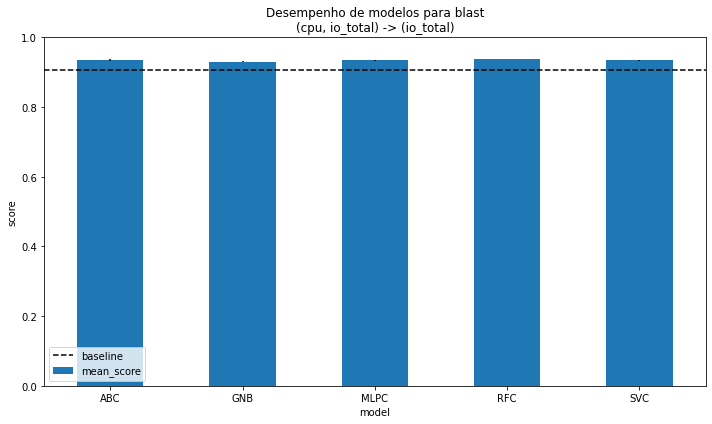

In [ ]:
results['blast_io+100'], evals['blast_io+100'] = run_experiment(app='blast', resources=['cpu', 'io_total'],
               target_resource='io_total', search_spaces=search_spaces(random_state=0),
               scoring='f1', random_state=0, verbose=0,
               max_samples=MAX_TRAIN_SAMPLES, target_step=100)
evals['blast_io+100']

train: (67469, 10) test: (17308, 10) target: io_total-up+200 baseline: io_total-baseline
X_train: (10000, 8) y_train: (10000,)
# Fitting for ABC
# Fitting for GNB
# Fitting for MLPC
# Fitting for RFC
# Fitting for SVC


,model,mean_score,std_score,params,steps
0,ABC,0.927116,0.003346,{'abc__n_estimators': 100},200
1,GNB,0.924465,0.000971,{'gnb__var_smoothing': 1e-09},200
2,MLPC,0.926643,0.001799,{'mlp__alpha': 0.1},200
3,RFC,0.928022,0.004384,{'rfc__max_features': 3},200
4,SVC,0.927294,0.000971,"{'svc__C': 1, 'svc__gamma': 'scale', 'svc__ker...",200
5,baseline,0.902472,NaN,NaN,200


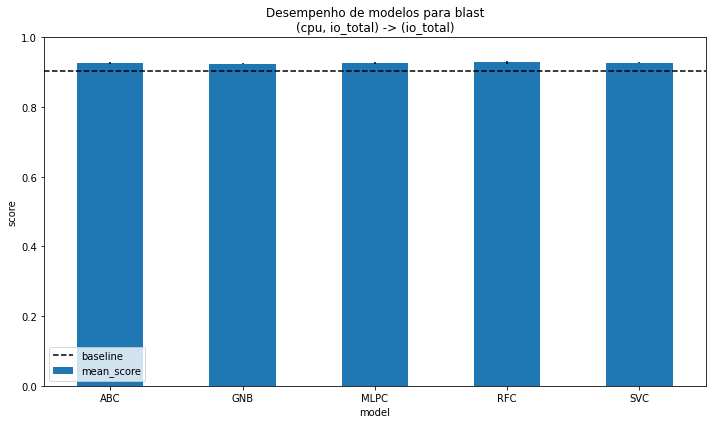

In [ ]:
results['blast_io+200'], evals['blast_io+200'] = run_experiment(app='blast', resources=['cpu', 'io_total'],
               target_resource='io_total', search_spaces=search_spaces(random_state=0),
               scoring='f1', random_state=0, verbose=0,
               max_samples=MAX_TRAIN_SAMPLES, target_step=200)
evals['blast_io+200']

## Exportar modelos

In [ ]:
import joblib
os.makedirs(MODEL_DIR, exist_ok=True)

In [ ]:
results.keys()

dict_keys(['hpl_cpu', 'hpl_cpu+20', 'hpl_cpu+100', 'hpl_cpu+200', 'hpl_io', 'hpl_io+20', 'hpl_io+100', 'hpl_io+200', 'iozone_cpu', 'iozone_cpu+20', 'iozone_cpu+100', 'iozone_cpu+200', 'iozone_io', 'iozone_io+20', 'iozone_io+100', 'iozone_io+200', 'montage_cpu', 'montage_cpu+20', 'montage_cpu+100', 'montage_cpu+200', 'montage_io', 'montage_io+20', 'montage_io+100', 'montage_io+200', 'blast_cpu', 'blast_cpu+20', 'blast_cpu+100', 'blast_cpu+200', 'blast_io', 'blast_io+20', 'blast_io+100', 'blast_io+200'])

In [ ]:
for model_name, searches in results.items():
    algorithm, search = max(searches, key=lambda r: r[1].best_score_)
    model = search.best_estimator_
    filename = os.path.join(MODEL_DIR, 'new', model_name + '_' + algorithm + '.joblib')
    joblib.dump(model, filename)
    print(filename)

/content/drive/MyDrive/ime/allan-matheus-mestrado/models/new/hpl_cpu_RFC.joblib
/content/drive/MyDrive/ime/allan-matheus-mestrado/models/new/hpl_cpu+20_ABC.joblib
/content/drive/MyDrive/ime/allan-matheus-mestrado/models/new/hpl_cpu+100_ABC.joblib
/content/drive/MyDrive/ime/allan-matheus-mestrado/models/new/hpl_cpu+200_RFC.joblib
/content/drive/MyDrive/ime/allan-matheus-mestrado/models/new/hpl_io_RFC.joblib
/content/drive/MyDrive/ime/allan-matheus-mestrado/models/new/hpl_io+20_RFC.joblib
/content/drive/MyDrive/ime/allan-matheus-mestrado/models/new/hpl_io+100_RFC.joblib
/content/drive/MyDrive/ime/allan-matheus-mestrado/models/new/hpl_io+200_GNB.joblib
/content/drive/MyDrive/ime/allan-matheus-mestrado/models/new/iozone_cpu_RFC.joblib
/content/drive/MyDrive/ime/allan-matheus-mestrado/models/new/iozone_cpu+20_RFC.joblib
/content/drive/MyDrive/ime/allan-matheus-mestrado/models/new/iozone_cpu+100_RFC.joblib
/content/drive/MyDrive/ime/allan-matheus-mestrado/models/new/iozone_cpu+200_RFC.joblib

In [ ]:
evals.keys()

dict_keys(['hpl_cpu', 'hpl_cpu+20', 'hpl_cpu+100', 'hpl_cpu+200', 'hpl_io', 'hpl_io+20', 'hpl_io+100', 'hpl_io+200', 'iozone_cpu', 'iozone_cpu+20', 'iozone_cpu+100', 'iozone_cpu+200', 'iozone_io', 'iozone_io+20', 'iozone_io+100', 'iozone_io+200', 'montage_cpu', 'montage_cpu+20', 'montage_cpu+100', 'montage_cpu+200', 'montage_io', 'montage_io+20', 'montage_io+100', 'montage_io+200', 'blast_cpu', 'blast_cpu+20', 'blast_cpu+100', 'blast_cpu+200', 'blast_io', 'blast_io+20', 'blast_io+100', 'blast_io+200'])

In [ ]:
evals['hpl_cpu']

,model,mean_score,std_score,params,steps
0,ABC,0.985944,0.003066,{'abc__n_estimators': 50},1
1,GNB,0.961407,0.008586,{'gnb__var_smoothing': 1e-09},1
2,MLPC,0.985551,0.002053,{'mlp__alpha': 0.01},1
3,RFC,0.989112,0.002557,{'rfc__max_features': 3},1
4,SVC,0.986637,0.001585,"{'svc__C': 1, 'svc__gamma': 'scale', 'svc__ker...",1
5,baseline,0.981272,NaN,NaN,1


In [ ]:
for model_name, searches_df in evals.items():
    filename = os.path.join(MODEL_DIR, 'new', 'evals', model_name + '.csv')
    searches_df.to_csv(filename)
    print(filename)

/content/drive/MyDrive/ime/allan-matheus-mestrado/models/new/evals/hpl_cpu.csv
/content/drive/MyDrive/ime/allan-matheus-mestrado/models/new/evals/hpl_cpu+20.csv
/content/drive/MyDrive/ime/allan-matheus-mestrado/models/new/evals/hpl_cpu+100.csv
/content/drive/MyDrive/ime/allan-matheus-mestrado/models/new/evals/hpl_cpu+200.csv
/content/drive/MyDrive/ime/allan-matheus-mestrado/models/new/evals/hpl_io.csv
/content/drive/MyDrive/ime/allan-matheus-mestrado/models/new/evals/hpl_io+20.csv
/content/drive/MyDrive/ime/allan-matheus-mestrado/models/new/evals/hpl_io+100.csv
/content/drive/MyDrive/ime/allan-matheus-mestrado/models/new/evals/hpl_io+200.csv
/content/drive/MyDrive/ime/allan-matheus-mestrado/models/new/evals/iozone_cpu.csv
/content/drive/MyDrive/ime/allan-matheus-mestrado/models/new/evals/iozone_cpu+20.csv
/content/drive/MyDrive/ime/allan-matheus-mestrado/models/new/evals/iozone_cpu+100.csv
/content/drive/MyDrive/ime/allan-matheus-mestrado/models/new/evals/iozone_cpu+200.csv
/content/dr

## Teste final só com os melhores modelos para cada aplicação para cada alvo

TODO

### HPL



In [ ]:
hpl_name, hpl_gs = max(results['hpl'], key=lambda r: r[1].best_score_)

In [ ]:
hpl_clf = hpl_gs.best_estimator_
hpl_clf

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('rfc',
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=None, max_features=3,
                                        max_leaf_nodes=None, max_samples=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=100, n_jobs=None,
                                        oob_score=False, random_state=None,
                                        verbose=0, warm_start=False))],
         verbose=False)

In [ ]:
y_final = final_test.pop(target).values
final_baseline = final_test.pop(baseline).values
X_final = final_test.values

In [ ]:
X_final.shape, y_final.shape, final_baseline.shape

In [ ]:
y_final_pred = clf.predict(X_final)

In [ ]:
y_final_pred.shape

In [ ]:
print('accuracy:', accuracy_score(y_final, y_final_pred))
print('baseline:', accuracy_score(y_final, final_baseline))

In [ ]:
print('comparando:', accuracy_score(y_final_pred, final_baseline))

In [ ]:
m, n = 70, 120
plt.figure(figsize=(16, 2))
plt.plot(y_final[m:n], 'bo', label='real data')
plt.plot(final_baseline[m:n], 'y*', label='previous repeated')
plt.plot(y_final_pred[m:n], 'rx', label='prediction')
plt.legend(loc='center right')
plt.grid(axis='x', )
plt.show()